In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras.models import load_model
import string
import pickle
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import statistics
import math



In [ ]:
!pip install datasets==1.18.1
from datasets import load_dataset
dataset = load_dataset("cfilt/iitb-english-hindi")

## Preparing Data

### TASK: Create Encder-Decoder LSTM model to convert Hindi sentences to English sentences.  

### 2. Read Data : IIT Bombay 

### Text Processing

In [ ]:
def removePunctuation(lines):
    # Remove punctuation
    lines[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in lines[:,0]]
    lines[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in lines[:,1]]
    return lines

In [ ]:
def toLowercase(lines):
    for i in range(len(lines)):
        lines[i,0] = lines[i,0].lower()   
        lines[i,1] = lines[i,1].lower()
    return lines

In [ ]:
from numpy import array
def createDataset(dataset, data_size,type):
    pairs=[] 
    for translation_pair in dataset[type]["translation"][:data_size]:
        source_sentence = translation_pair["hi"]
        target_sentence = translation_pair["en"]
        pairs.append([source_sentence, target_sentence])
    pairs = array(pairs)
    pairs= toLowercase(pairs)
    pairs=removePunctuation(pairs)

    lines= pd.DataFrame(columns=[ "hindi","eng"], data=pairs)
    lines= lines[:data_size]
   
    return lines
      


### 3) Preparing input data for the Encoder ( `encoder_input_data` )

In [ ]:
def createInputDataForEncoder(lines):
    hindi_lines = list()
    for line in lines.hindi:
        hindi_lines.append( line ) 
        
    tokenizer = preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts( hindi_lines ) 
    tokenized_hindi_lines = tokenizer.texts_to_sequences( hindi_lines ) 
    length_list = list()

    for token_seq in tokenized_hindi_lines:
        length_list.append( len( token_seq ))

    # max_input_length = np.array( length_list ).max()
    max_input_length = math.floor(statistics.mode(length_list))

    padded_hindi_lines = preprocessing.sequence.pad_sequences( tokenized_hindi_lines , maxlen=max_input_length , padding='post' )
    encoder_input_data = np.array( padded_hindi_lines )
   
    hindi_word_dict = tokenizer.word_index
    num_hindi_tokens = len( hindi_word_dict )+1
    # print("Hindi Dictionary" ,hindi_word_dict  )
    return max_input_length, num_hindi_tokens, encoder_input_data, hindi_word_dict
   


                

### Create Dataset for Decoder

### 4) Preparing input data for the Decoder ( `decoder_input_data` )

In [ ]:

def createInputDataForDecoder(lines):
    eng_lines = list()
    for line in lines.eng:
        eng_lines.append( '<START> ' + line + ' <END>' )  

    tokenizer = preprocessing.text.Tokenizer(oov_token=1)
    tokenizer.fit_on_texts( eng_lines ) 
    tokenized_eng_lines = tokenizer.texts_to_sequences( eng_lines ) 

    length_list = list()
    for token_seq in tokenized_eng_lines:
        length_list.append( len( token_seq ))
   
    max_output_length = math.floor(statistics.mode(length_list))
    print( 'English max length is {}'.format( max_output_length ))

    padded_eng_lines = preprocessing.sequence.pad_sequences( tokenized_eng_lines , maxlen=max_output_length, padding='post' )
    decoder_input_data = np.array( padded_eng_lines  )
    print( 'Decoder input data shape -> {}'.format( decoder_input_data.shape ))

    eng_word_dict = tokenizer.word_index
    num_eng_tokens = len( eng_word_dict )+1
    print( 'Number of English tokens = {}'.format( num_eng_tokens))

    return max_output_length, num_eng_tokens, decoder_input_data, eng_word_dict, tokenized_eng_lines

### 5) Preparing target data for the Decoder ( decoder_target_data ) 

In [ ]:
def createDecoderTargetData(tokenized_eng_lines, max_output_length, num_eng_tokens):
    decoder_target_data = list()
    for token_seq in tokenized_eng_lines:
        decoder_target_data.append( token_seq[ 1 : ] ) 
        
    padded_eng_lines = preprocessing.sequence.pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
    onehot_eng_lines = utils.to_categorical( padded_eng_lines , num_eng_tokens )
    decoder_target_data = np.array( onehot_eng_lines )
    print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape ))
    return decoder_target_data

### 1) Defining the Encoder-Decoder model

In [ ]:

def create_encoder_decoder(encoder_inputs,encoder_states,decoder_lstm,decoder_embedding,decoder_dense,decoder_inputs):
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [ ]:
def createEncoderDecoderModel(max_input_length, max_output_length, num_hindi_tokens, num_eng_tokens):
    encoder_inputs = Input(shape=( max_input_length ,  ))
    encoder_embedding = Embedding( num_hindi_tokens, 256 , mask_zero=True ) (encoder_inputs)
    encoder_outputs , state_h , state_c = LSTM( 256 , return_state=True , recurrent_dropout=0.2 , dropout=0.2 )( encoder_embedding )
    encoder_states = [ state_h , state_c ]

    decoder_inputs = Input(shape=( max_output_length , ))
    decoder_embedding = Embedding( num_eng_tokens, 256 , mask_zero=True) (decoder_inputs)
    decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
    decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
    decoder_dense = Dense( num_eng_tokens , activation=tf.keras.activations.softmax ) 
    output = decoder_dense ( decoder_outputs )

    model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')
    encoder_model , decoder_model= create_encoder_decoder(encoder_inputs,encoder_states,decoder_lstm,decoder_embedding,decoder_dense,decoder_inputs)
    return model ,encoder_model , decoder_model



### Save Encoder And Decoder Parameters

In [ ]:

def save_models_and_parameters(lines,model,encoder_model , decoder_model, max_input_length, num_hindi_tokens, hindi_word_dict,max_output_length,num_eng_tokens,eng_word_dict):
    model_name = str(lines.count().eng)
    !mkdir $model_name
    !ls
    model.save( model_name+'/model.h5' ) 
    # save encoder model
    encoder_model.save( model_name+'/enc_model.h5' ) 
    # save decoder model
    decoder_model.save( model_name+'/dec_model.h5' ) 

    # encoder parameters
    encoder_parameters={
        'max_encoder_seq_length': max_input_length,
        'num_encoder_tokens': num_hindi_tokens,
        
    
    }
    encoder_dictionary=  hindi_word_dict


    # decoder parameters
    decoder_parameters={
        'max_decoder_seq_length':  max_output_length,
        'num_decoder_tokens': num_eng_tokens,

    }

    decoder_dictionary=  eng_word_dict
    parameters=model_name+"/parameters/"
    dictionaries=model_name+"/dictionaries/"
    !mkdir $parameters
    !mkdir $dictionaries
    paramters_path=parameters
    dictionaries_path=dictionaries

    # save encoder parameter
    with open(paramters_path+'encoder_parameters.pickle', 'wb') as handle:
        pickle.dump(encoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder dictionary
    with open(dictionaries_path+'encoder_dictionary.pickle', 'wb') as handle:
        pickle.dump(encoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder parameter
    with open(paramters_path+'decoder_parameters.pickle', 'wb') as handle:
        pickle.dump(decoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder parameter
    with open(dictionaries_path+'decoder_dictionary.pickle', 'wb') as handle:
        pickle.dump(decoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    print("Model ",model_name," saved successfully!")    




### Handle Helper Functions 

In [ ]:
!ls

In [ ]:
import os
import sys

def handle_helper_functions():
    print(sys.path)
    directory_path = os.path.abspath(os.path.join('../../helper'))
    if directory_path not in sys.path:
        sys.path.append(directory_path)    

    translation_path=os.path.abspath(os.path.join('../../utils')) 
    if translation_path not in sys.path:
        sys.path.append(translation_path)   
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/test/helper')                                       
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/utils')
    print(sys.path)
    

handle_helper_functions()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import tensorflow_text as text
from scoreTest import get_cosine_val, get_BLEU_score, get_ROUGE_score
from translate import  translate_sentence

### Get Summary Statistics For Every Model

In [ ]:
def get_model_statistics_summary(model_path,path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary, encoderPath, decoderPath, lines ):

################################## START  ##################################
    reconstructed_model = keras.models.load_model(model_path)
    plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)
    reconstructed_model.summary()


    ## Load Dictionaries and Parameters 
    path_encoder_parameters= path_encoder_parameters
    path_encoder_dictionary= path_encoder_dictionary
    path_decoder_parameters= path_decoder_parameters
    path_decoder_dictionary= path_decoder_dictionary

    # loading
    with open(path_encoder_parameters, 'rb') as handle:
        encoder_parameters = pickle.load(handle)

    # loading
    with open(path_encoder_dictionary, 'rb') as handle:
        encoder_dictionary = pickle.load(handle)

    # loading
    with open(path_decoder_parameters, 'rb') as handle:
        decoder_parameters= pickle.load(handle)

    # loading
    with open(path_decoder_dictionary, 'rb') as handle:
        decoder_dictionary = pickle.load(handle)    

    print(encoder_parameters)
    # encoder_dictionary
    print(decoder_parameters)
    # decoder_dictionary

    encoder_inputs = reconstructed_model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)
    latent_dim = 256  # Note: may be need to save in drive as well


    num_decoder_tokens =decoder_parameters['num_decoder_tokens']
    max_output_length= decoder_parameters['max_decoder_seq_length']
    max_input_length= encoder_parameters['max_encoder_seq_length']

    encoder_word_dict=encoder_dictionary
    decoder_word_dict= decoder_dictionary


    decoder_inputs = Input(shape=( max_output_length , ))
    decoder_embedding = Embedding( num_decoder_tokens, 256 , mask_zero=True) (decoder_inputs)

    decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
    decoder_dense = Dense( num_decoder_tokens , activation=tf.keras.activations.softmax ) 


   

    def make_inference_models():
        
            encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
            
            decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
            decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
            
            decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
            
            decoder_outputs, state_h, state_c = decoder_lstm(
                decoder_embedding , initial_state=decoder_states_inputs)
            decoder_states = [state_h, state_c]
            decoder_outputs = decoder_dense(decoder_outputs)
            decoder_model = tf.keras.models.Model(
                [decoder_inputs] + decoder_states_inputs,
                [decoder_outputs] + decoder_states)
            
            return encoder_model , decoder_model


    enc_model , dec_model = make_inference_models()


################################## END  ##################################

    ## Get sentences to test the model

    sample_sentences= lines
    sample_sentences

    # Reference Token 

    reference_tokens=[]

    for line in sample_sentences['eng']:
       
        reference_tokens.append( line.split() )

    df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

    df["reference"]= reference_tokens

    ####### START Calculate Cosine Similarity for two sentences
    scores=[]
    for line in sample_sentences['eng']:
        translation= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        result= get_cosine_val (translation, line)
        scores.append(result)

    df["cosine_similarity"]= scores    ## Cosine score calculated

    ####### END Calculate Cosine Similarity for two sentences
    

    # Candidate Tokens 
    candidate_tokens=[]


    for line in sample_sentences['hindi']:
    
        result= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        temp =result.split()
        temp= temp[:-1]
        candidate_tokens.append(temp)
        

    df["candidate"]= candidate_tokens


    ## Calculate BLEU score

    scores=get_BLEU_score(df,sentence_bleu)
    df["bleu_score"]= scores    ## BLEU score calculated

    ## Calcualte ROUGE score
    scores= get_ROUGE_score(df, pd, tf,text)
    df["rouge_score"]= scores  ## ROUGE score calculated

    rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

    average_f_measure = rouge_metric['f_measure'].mean()
    average_p_measure = rouge_metric['p_measure'].mean()
    average_r_measure = rouge_metric['r_measure'].mean()
    average_cosine= df['cosine_similarity'].mean()
    average_bleu= df['bleu_score'].mean()

    ## return BLEU and ROUGE score to the list 
    return [average_f_measure, average_p_measure,average_r_measure, average_cosine, average_bleu]

        

    

In [ ]:
data_size=100000

pool_oftexts=createDataset(dataset=dataset,data_size=data_size, type="train")
pool_oftexts=pool_oftexts[500:]


In [ ]:
len(pool_oftexts)

In [ ]:
model_size=[1000, 5000, 10000, 15000]
my_list_of_trained_models=[] 

In [ ]:
for item in model_size:
    lines= pool_oftexts.sample(n = item)   
    max_input_length, num_hindi_tokens, encoder_input_data, input_dict= createInputDataForEncoder(lines=lines)
    max_output_length, num_eng_tokens, decoder_input_data, eng_word_dict, tokenized_eng_lines =createInputDataForDecoder(lines=lines)
    decoder_target_data= createDecoderTargetData(tokenized_eng_lines, max_output_length, num_eng_tokens)
    model, encoder_model , decoder_model= createEncoderDecoderModel(max_input_length, max_output_length, num_hindi_tokens, num_eng_tokens)
    mc = tf.keras.callbacks.ModelCheckpoint('my_nmt_model_min_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=250,  epochs=100  ,validation_split = 0.1, callbacks=[mc], verbose=1    ) 
    my_list_of_trained_models.append(model)
    save_models_and_parameters(lines,model,encoder_model , decoder_model, max_input_length,num_hindi_tokens,input_dict,max_output_length, num_eng_tokens,eng_word_dict)


## Think what should be done with variable history
      

### Get Test Sentences

In [ ]:
data_size=2500
lines=createDataset(dataset=dataset,data_size=data_size, type="test")
lines.tail()

In [ ]:
pip install pydot graphviz

In [ ]:
def to_string(number):
  return str(number) 

string_numbers_iterator = map(to_string, model_size)
model_list = list(string_numbers_iterator)
path='./'



In [ ]:

stat=[]
for item in model_list:

    model_path= path+item+"/model.h5" 
    path_encoder_parameters= path+item+"/parameters/encoder_parameters.pickle" 
    path_encoder_dictionary= path+item+"/dictionaries/encoder_dictionary.pickle" 
    path_decoder_parameters= path+item+"/parameters/decoder_parameters.pickle" 
    path_decoder_dictionary= path+item+"/dictionaries/decoder_dictionary.pickle" 
    encoderPath= path+item+"/enc_model.h5" 
    decoderPath= path+item+"/dec_model.h5" 
    # print(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result= get_model_statistics_summary(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath, lines)
    result.insert(0, item)
    stat.append(result)
    print(result)

table =pd.DataFrame(columns=["Dataset Size","average_f_measure", "average_p_measure","average_r_measure", "average_cosine" ,"average_bleu"], data=stat)
table

### Visualizations

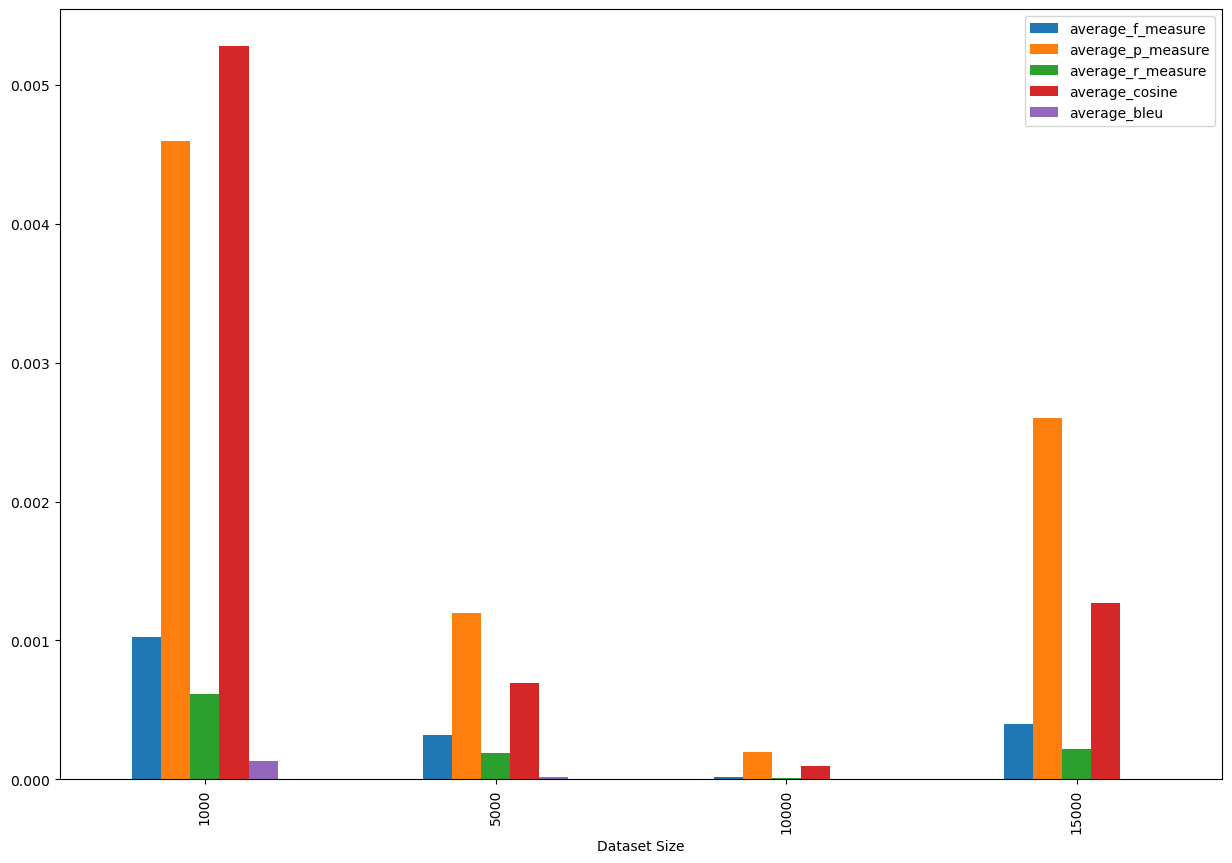

In [25]:
import matplotlib.pyplot as plot
from matplotlib.ticker import ScalarFormatter
#,figsize=(10,15)

table.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True)

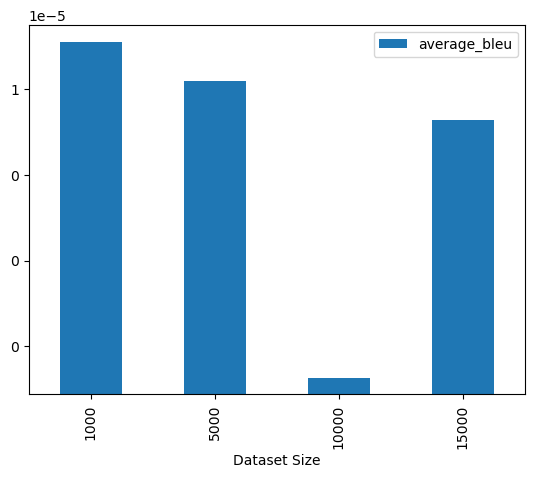

In [26]:
table.plot.bar(x="Dataset Size",y="average_bleu")
plot.yscale("log")
plot.gca().yaxis.set_major_formatter(ScalarFormatter())

plot.show(block=True)

### Save Performance Metrics

In [27]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H:%M")
path= '../analytics/'+dt_string+".json"
table.to_json(r''+path,orient='records')


### Read Performance Metrics

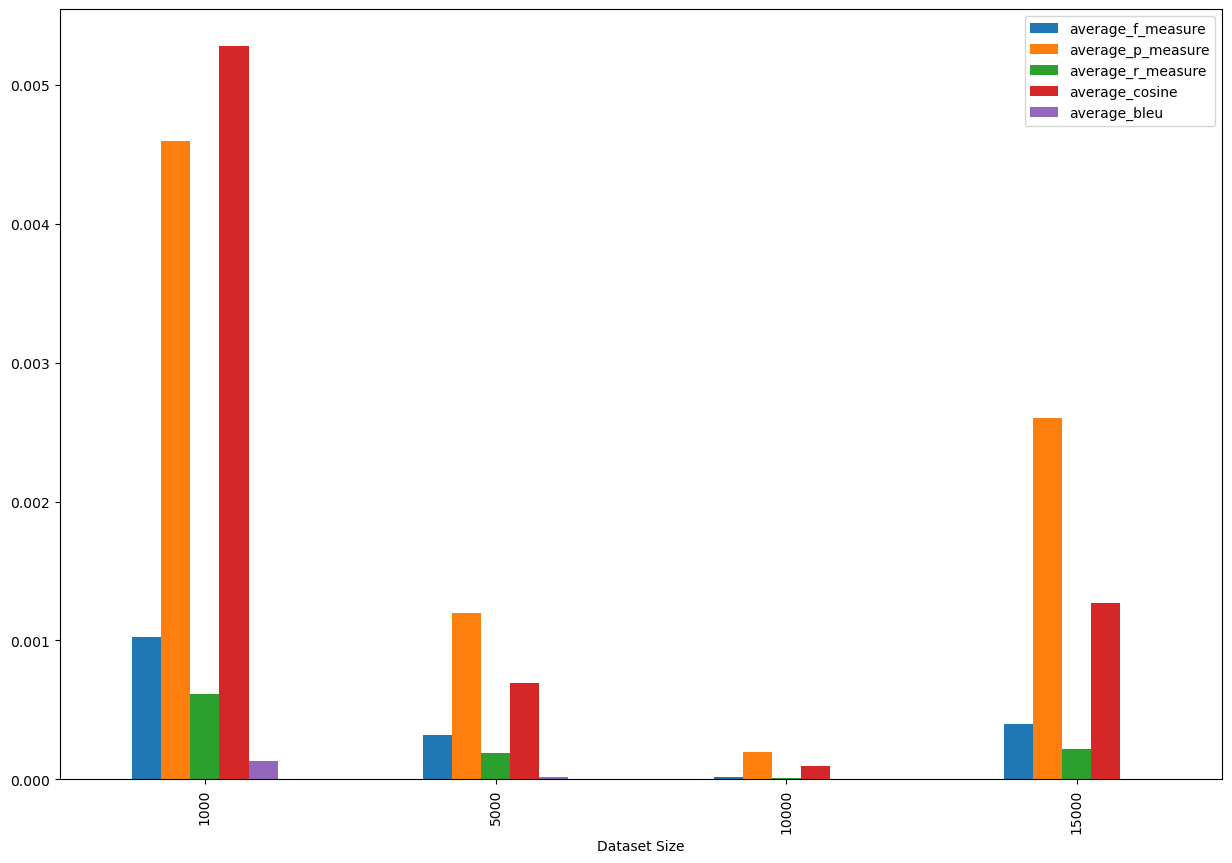

In [28]:
read_json=pd.read_json(path)

read_json.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True)